## Import Libs

In [55]:
import os
import time
import random
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

## store pictures and labels

In [56]:
pictures = []
labels = []
planesnet_dir = ('planesnet')

#%% load images
files = glob.glob (planesnet_dir + "/*.png") # image path
# shuffle
random.Random(42).shuffle(files)

for picture in files:
    image = cv2.imread (picture)
    im_name = picture.replace(planesnet_dir + "\\","")
    labels.append(im_name[0])
    pictures.append(image)

Text(0.5, 1.0, '1')

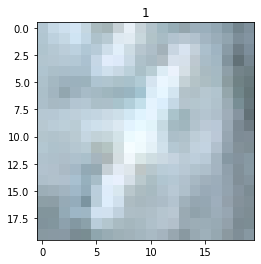

In [57]:
plt.imshow(pictures[0])
plt.title(labels[0])

## Create HOG Features

In [58]:
## params
winSize = (20,20)
blockSize = (10,10)
blockStride = (1,1)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
signedGradients = True
 
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradients)

hog_features = []

for picture in pictures:
    descriptor = hog.compute(picture)
    hog_features.append(descriptor)

num_features = descriptor.shape[0]
print("total count of features: ", num_features)

total count of features:  1089


## Split Dataset

In [61]:
# take smaller amount of images for developing
develop = True

# 32,000 Instanzen - 20,480 Train, 5,120 Val, 6400 Test
if develop:
    X_train = np.array(hog_features[0:5000]).reshape(5000,num_features)
    y_train = np.array(labels[0:5000])
    X_val = np.array(hog_features[5000:6000]).reshape(1000,num_features)
    y_val = np.array(labels[5000:6000])
    X_test = np.array(hog_features[6000:7000]).reshape(1000,num_features)
    y_test = np.array(labels[6000:7000])
else:
    X_train = np.array(hog_features[0:20480]).reshape(20480,num_features)
    y_train = np.array(labels[0:20480])
    X_val = np.array(hog_features[20480:25600]).reshape(5120,num_features)
    y_val = np.array(labels[20480:25600])
    X_test = np.array(hog_features[25600:]).reshape(6400,num_features)
    y_test = np.array(labels[25600:])

In [62]:
hog_features[0].shape

(1089, 1)

## Train baseline model

In [63]:
from sklearn.svm import SVC
import timeit

clf = SVC(kernel='linear', random_state=42)
start = timeit.default_timer()
clf.fit(X_train, y_train)
stop = timeit.default_timer()
accuracy = clf.score(X_val, y_val)
print("accuracy score of baseline model: ", accuracy)
print('elapsed time: ', round(stop - start, 2), " seconds")  

accuracy score of baseline model:  0.905
elapsed time:  10.44  seconds


## Principal Component Analysis (PCA)

In [64]:
from sklearn.decomposition import PCA

# keep componets to optain 95% of the explained variance
pca = PCA(.95)
pca.fit(X_train)
X_train_decomposed = pca.transform(X_train)
X_val_decomposed = pca.transform(X_val)
X_test_decomposed = pca.transform(X_test)

print("number of features after pca: ", pca.n_components_)

number of features after pca:  89


## Train baseline model after pca

In [65]:
clf = SVC(kernel='linear', random_state=42)
start = timeit.default_timer()
clf.fit(X_train_decomposed, y_train)
stop = timeit.default_timer()
accuracy = clf.score(X_val_decomposed, y_val)
print("arruracy score of baseline model after pca: ", accuracy)
print('elapsed time: ', round(stop - start, 2), " seconds") 

arruracy score of baseline model after pca:  0.902
elapsed time:  1.57  seconds


## Grid Search

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['linear','rbf'],
              'C': [0.001,0.01,0.1,1,10,100],
              'gamma': [0.001,0.01,0.1,1,10,100]}

grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, verbose=0)
grid_search.fit(X_train_decomposed, y_train)
best_model = grid_search.best_estimator_        
best_idx = grid_search.best_index_
grid_results = pd.DataFrame(grid_search.cv_results_)

## Evaluation

In [77]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
y_pred_val = grid_search.predict(X_val_decomposed)
y_pred_test = grid_search.predict(X_test_decomposed)
print(" ### Validation Set ### ")
print("confusion matrix:")
print(confusion_matrix(y_val, y_pred_val))
print("")
print("Accuracy: ", accuracy_score(y_val, y_pred_val))
print('\n')
print(classification_report(y_val, y_pred_val, target_names=["no plane","plane"]))


print("### Test Set ### ")
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred_test))
print("")
print("Accuracy: ", accuracy_score(y_test, y_pred_test))
print('\n')
print(classification_report(y_test, y_pred_test, target_names=["no plane","plane"]))

 ### Validation Set ### 
confusion matrix:
[[731  14]
 [ 24 231]]

Accuracy:  0.962


              precision    recall  f1-score   support

    no plane       0.97      0.98      0.97       745
       plane       0.94      0.91      0.92       255

    accuracy                           0.96      1000
   macro avg       0.96      0.94      0.95      1000
weighted avg       0.96      0.96      0.96      1000

### Test Set ### 
confusion matrix:
[[724  18]
 [ 22 236]]

Accuracy:  0.96


              precision    recall  f1-score   support

    no plane       0.97      0.98      0.97       742
       plane       0.93      0.91      0.92       258

    accuracy                           0.96      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.96      0.96      0.96      1000

